In [143]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import pathlib

In [145]:
# Constants
data_dir = './Skin_Diseases'
batch_size = 32
img_height = 180
img_width = 180

# Make sure the path is correct
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist")

dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

print(dataset)
print("Class names:", dataset.class_names)

Found 27146 files belonging to 10 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Class names: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus', 'Seborrheic Keratoses', 'Tinea Ringworm Candidiasis', 'Warts Molluscum']


In [174]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

Found 27146 files belonging to 10 classes.
Using 21717 files for training.
Found 27146 files belonging to 10 classes.
Using 5429 files for validation.


Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


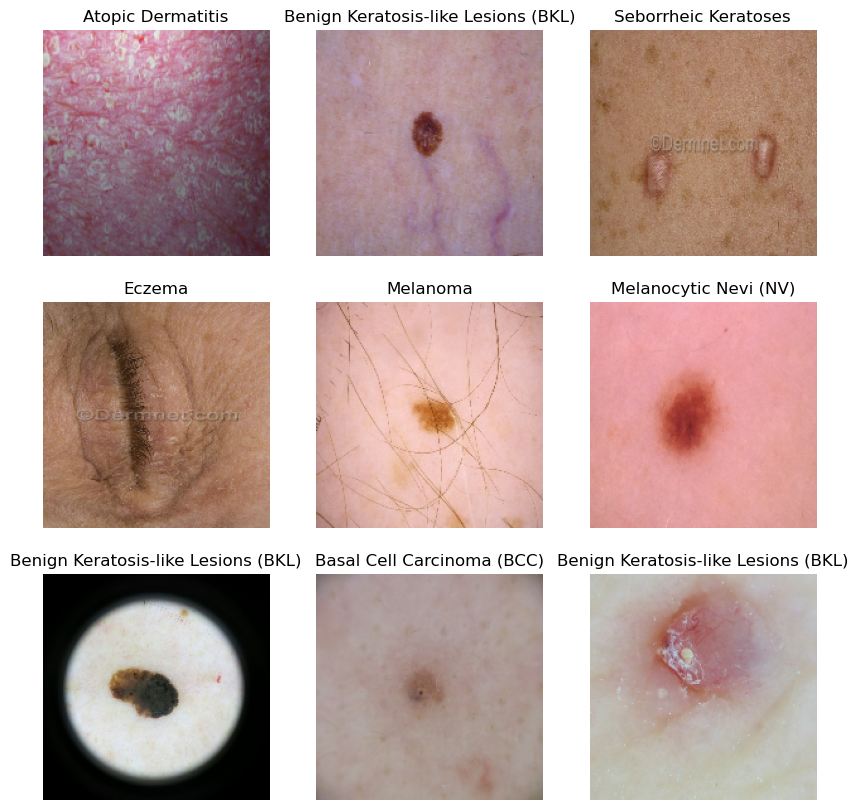

In [147]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

2024-11-03 14:24:33.050102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5148: Filling up shuffle buffer (this may take a while): 507 of 1000
2024-11-03 14:24:36.600877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


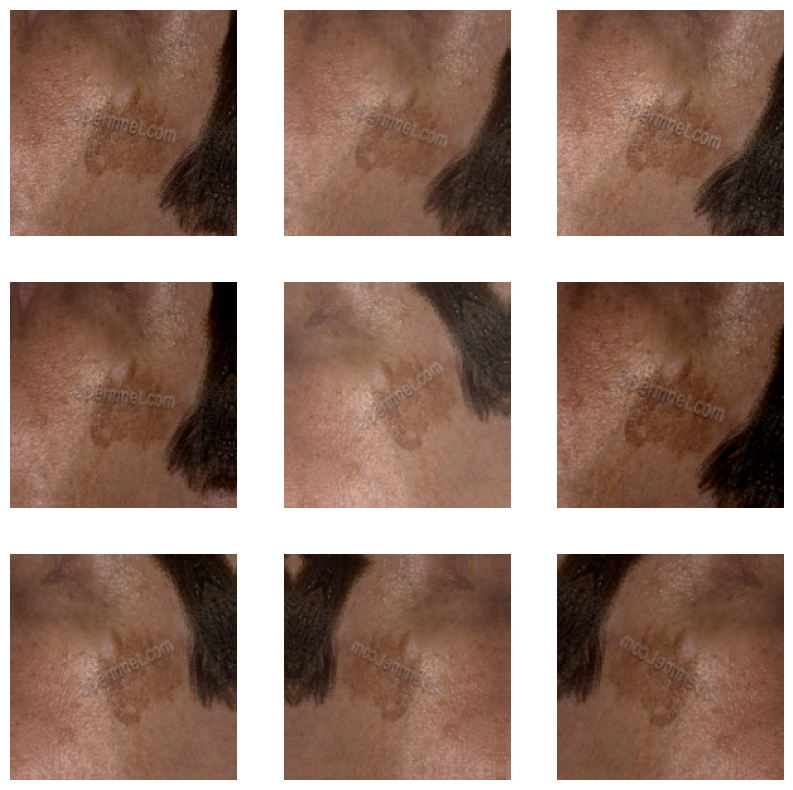

In [148]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

inputs = layers.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomCrop(height=180, width=180),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [150]:
model = Sequential([
    inputs,
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,930 (15.22 MB)

 Trainable params: 3,989,930 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 100s 143ms/step - accuracy: 0.3976 - loss: 1.8088 - val_accuracy: 0.5257 - val_loss: 1.4784 - learning_rate: 0.0010
Epoch 2/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 118s 173ms/step - accuracy: 0.5019 - loss: 1.4946 - val_accuracy: 0.5502 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 3/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 110s 161ms/step - accuracy: 0.5336 - loss: 1.4027 - val_accuracy: 0.5612 - val_loss: 1.3212 - learning_rate: 0.0010
Epoch 4/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 106s 157ms/step - accuracy: 0.5469 - loss: 1.3657 - val_accuracy: 0.5892 - val_loss: 1.2438 - learning_rate: 0.0010
Epoch 5/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 197s 290ms/step - accuracy: 0.5568 - loss: 1.3285 - val_accuracy: 0.5765 - val_loss: 1.2479 - learning_rate: 0.0010
Epoch 6/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 189s 278ms/step - accuracy: 0.5658 - loss: 1.2976 - val_accuracy: 0.5681 - val_loss: 1.2877 - learning_rate: 0.0010
Epoch 7/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 179s 264ms/step - accura

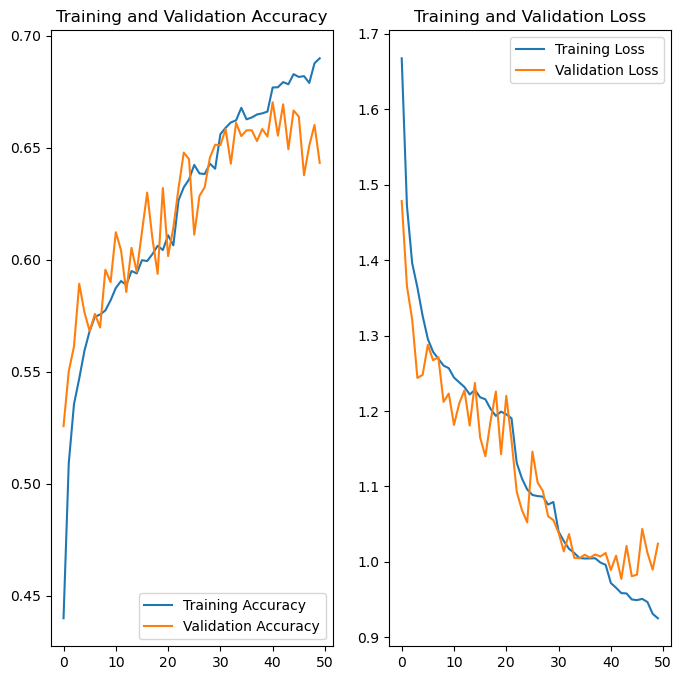

In [151]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss
    factor=0.5,          # Reduces the learning rate by half when triggered
    patience=5,          # Waits for 5 epochs before reducing the learning rate
    min_lr=1e-6          # Sets the minimum learning rate
)

epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
        callbacks=[lr_schedule]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Total Sum of Confusion Matrix Values: 5430


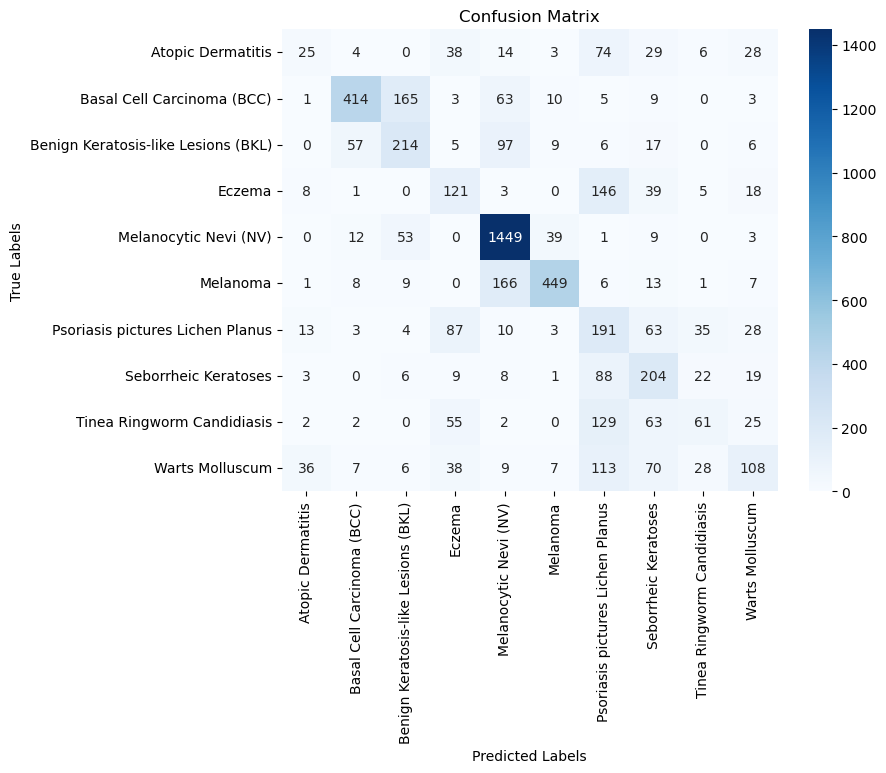

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Sum all values in the confusion matrix
total_sum = np.sum(cm)
print("Total Sum of Confusion Matrix Values:", total_sum)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


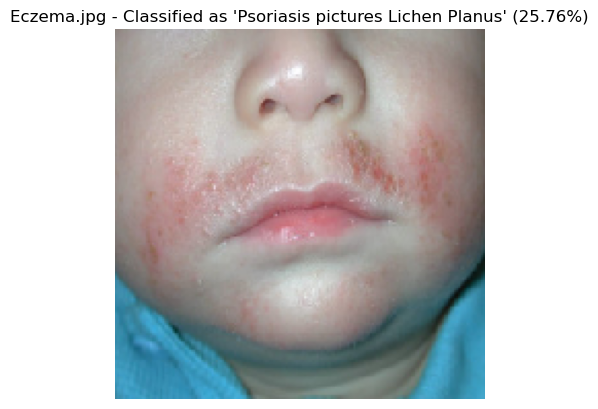

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


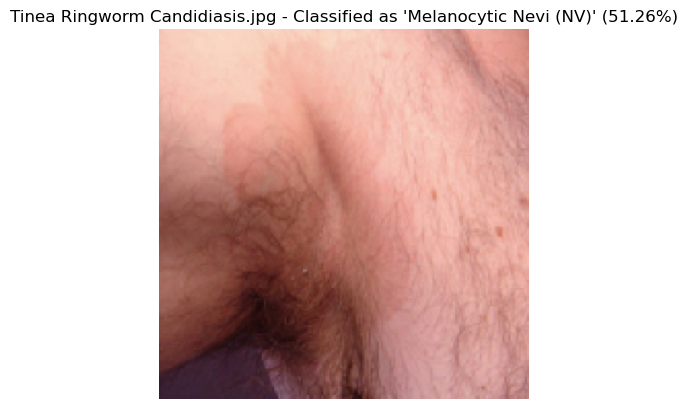

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


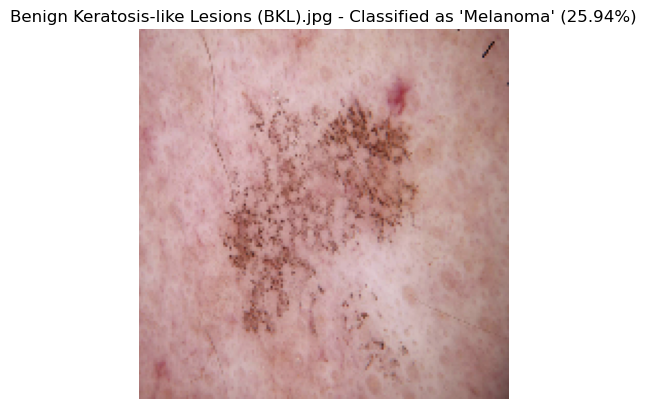

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


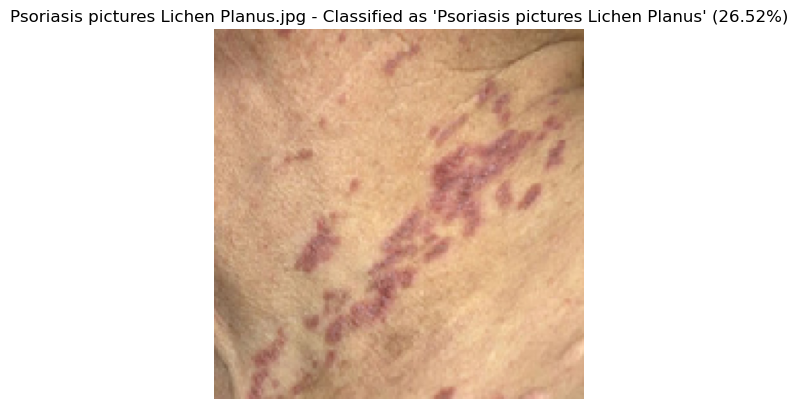

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


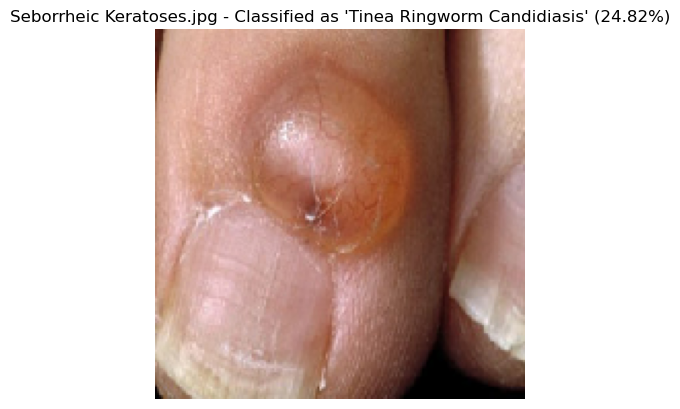

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


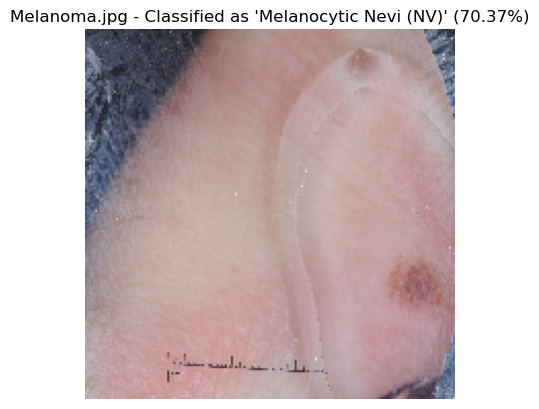

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


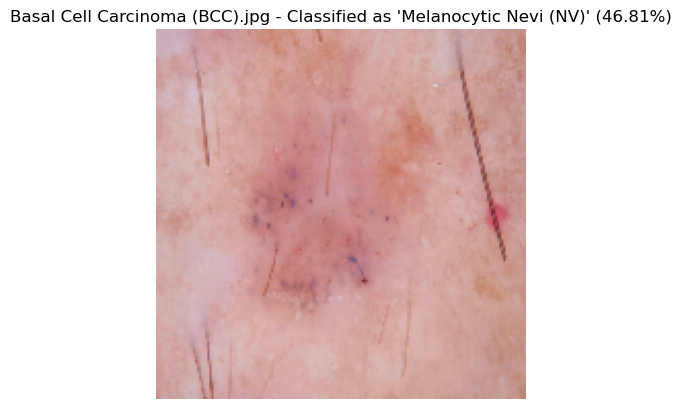

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


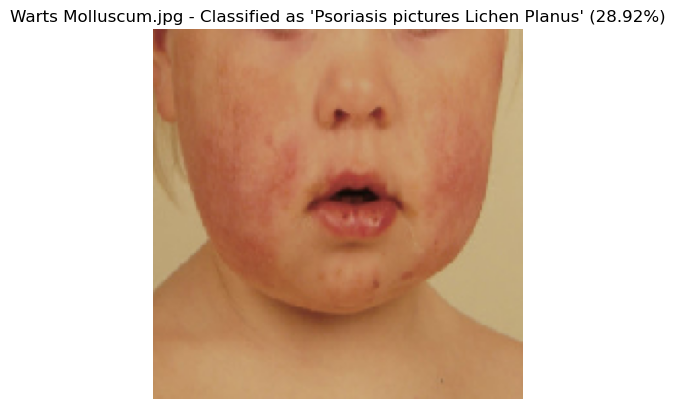

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


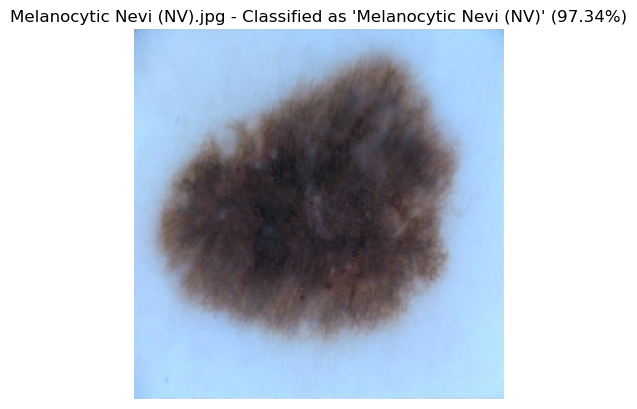

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


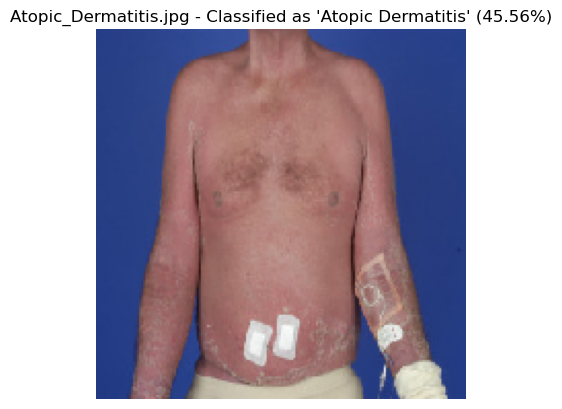

In [153]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

unseen_images_dir = "Unseen_images2"  # Path to the directory containing unseen images

for image_file in os.listdir(unseen_images_dir):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure only image files are processed
        image_path = os.path.join(unseen_images_dir, image_file)
        
        # Load and prepare the image
        img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Make prediction
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        predicted_class = class_names[np.argmax(score)]
        confidence = 100 * np.max(score)
        
        # Display the image with the prediction
        plt.figure()
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.title(f"{image_file} - Classified as '{predicted_class}' ({confidence:.2f}%)")
        plt.show()


In [154]:
model.save('skin_disease_classifier.keras')
loaded_model = keras.models.load_model('skin_disease_classifier.keras')

In [172]:
from sklearn.metrics import classification_report, confusion_matrix
true_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
                                     precision    recall  f1-score   support

                  Atopic Dermatitis       0.25      0.14      0.18       221
         Basal Cell Carcinoma (BCC)       0.87      0.62      0.72       673
Benign Keratosis-like Lesions (BKL)       0.56      0.55      0.55       410
                             Eczema       0.43      0.47      0.45       342
              Melanocytic Nevi (NV)       0.82      0.94      0.88      1567
                           Melanoma       0.86      0.84      0.85       658
   Psoriasis pictures Lichen Planus       0.38      0.42      0.40       439
               Seborrheic Keratoses       0.44      0.53      0.48       357
         Tinea Ringworm Candidiasis       0.31      0.41      0.35       345
                    Warts Molluscum       0.49      0.29      0.36       417

                           accuracy                           0.64      5429
                          macro 